In [13]:
import matplotlib.pyplot as plt
import numpy as np

from model import Generator

In [15]:
import os

import torch
from torch.autograd import Variable
from loguru import logger

from generation.utils import get_config_path, read_json, get_checkpoint_dir


class InferenceModel:
    def __init__(self, generator_class, run_id, epoch=None, batch_size=None):
        self.run_id = run_id
        self.config = read_json(get_config_path(run_id))
        self.batch_size = batch_size or self.config["batch_size"]
        self.generator = generator_class(self.config).to(self.config["device"])
        self._load_checkpoint(epoch)

    def _load_checkpoint(self, epoch=None):
        last_epoch = self.config["save_each"] * ((self.config["epochs_num"] - 1) // self.config["save_each"])
        epoch = epoch or last_epoch
        checkpoint_dir = get_checkpoint_dir(self.run_id)
        checkpoint_path = os.path.join(checkpoint_dir, f"generator_{epoch}.pt")
        self.generator.load_state_dict(torch.load(checkpoint_path))
        self.generator.eval()
        logger.info(f"Restored checkpoint from epoch {epoch}")

    @torch.no_grad()
    def generate(self, labels):
        samples_num = len(labels)
        samples = []
        cur_idx = 0
        for i in range((samples_num - 1) // self.batch_size + 1):
            if i == samples_num // self.batch_size:
                batch_size = samples_num % self.batch_size
            else:
                batch_size = self.batch_size
            z = Variable(torch.randn(batch_size, self.config['z_dim'] + 1))
            z[:, 0] = torch.tensor(labels[cur_idx: cur_idx + batch_size])
            z = z.to(self.config['device'])
            sample = self.generator(z)
            samples.append(sample)
            cur_idx += batch_size
        samples = torch.cat(samples)
        return samples

In [16]:
model = InferenceModel(Generator, '2djzfp50', 498)

2021-04-28 19:45:03.242 | INFO     | __main__:_load_checkpoint:25 - Restored checkpoint from epoch 498


In [ ]:
from dataset import _FRAC_VALUES


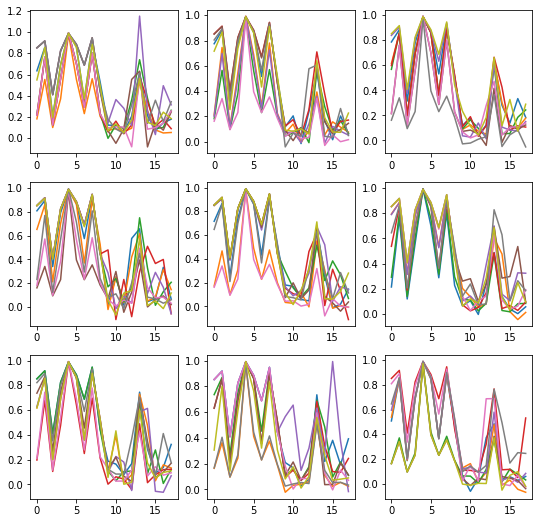

In [30]:
f, ax = plt.subplots(3, 3, figsize=(9, 9))

for idx, frac in enumerate(_FRAC_VALUES):
    labels = []
    for frac in _FRAC_VALUES:
        labels += [0.1] * 1

    generated_signals = model.generate(labels).cpu()
    
    ax[idx // 3][idx % 3].set_label(f'Energy {frac}')
    
    for signal in generated_signals:
        ax[idx // 3][idx % 3].plot(signal)

plt.show()

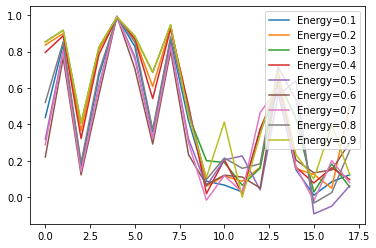

In [26]:
for idx, signal in enumerate(generated_signals):
    plt.plot(signal, label=f'Energy={_FRAC_VALUES[idx]}')
plt.legend()